In [1]:
%pip install keras
%pip install tensorflow
%pip install pydot
%pip install opencv-python


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D 
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras import backend as K
from keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import class_weight

import tensorflow as tf

import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



programador = "Tiago"
RSEED = 0

In [3]:
#para fazer a leitura das imagens de diferentes tamanhos
labels = ['no', 'yes']
img_size = 140
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img),0)[...,::-1] #read black and white
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

C:\Users\Tiago\AppData\Local\Temp/ipykernel_23216/1670941219.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


Weight for class 0: 1.29
Weight for class 1: 0.82


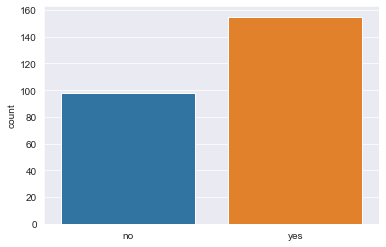

In [4]:
if programador == "Vasco_portatil":
    data = get_data("C:\\Users\\Vasco\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\dataset")
elif programador == "Vasco":
    data = get_data("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\dataset")
elif programador == "Tiago":
    data = get_data("C:\\Users\\Tiago\\Universidade de Aveiro\\Vasco Costa - AIA\dataset")

#print(data)
l = []
count_0 = 0
count_1 = 0
for i in data:
    if(i[1] == 0):
        l.append(labels[0])
        count_0 += 1
    else:
        l.append(labels[1])
        count_1 += 1
sns.set_style('darkgrid')
sns.countplot(l)

weight_for_0 = (1 / count_0)*(count_0+count_1)/2.0 
weight_for_1 = (1 / count_1)*(count_0+count_1)/2.0 

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Text(0.5, 1.0, 'yes')

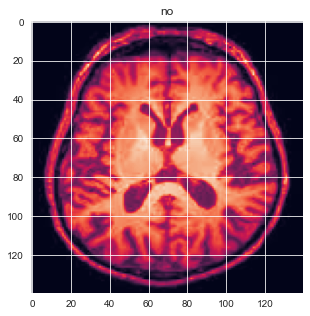

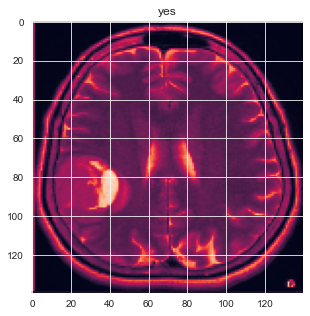

In [5]:
plt.figure(figsize = (5,5))
plt.imshow(data[1][0])
plt.title(labels[data[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(data[-1][0])
plt.title(labels[data[-1][1]])

In [6]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

x = np.array(x) / 255
x = x[..., np.newaxis]
y = np.array(y).reshape((-1,1))

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=RSEED)

In [8]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
from random import seed


datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip = True)  # randomly flip images

datagen.fit(x_train,seed=RSEED)

model = Sequential()
model.add(Conv2D(64,3,padding="same", activation="relu", input_shape=(img_size,img_size,1)))
model.add(MaxPool2D())


model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(img_size,img_size,1)))
model.add(MaxPool2D())


model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())


model.add(Conv2D(16, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(1, activation="sigmoid"))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 140, 140, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 70, 70, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 70, 70, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 35, 35, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 32)       0

In [10]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['acc', f1_m, precision_m, recall_m])

In [11]:
history = model.fit(x_train, y_train,
                    epochs=30,
                    validation_data=(x_test, y_test),
                    class_weight=class_weights)

Epoch 1/30
6/6 [==============================] - 13s 2s/step - loss: 0.6894 - acc: 0.5876 - f1_m: 0.6877 - precision_m: 0.6963 - recall_m: 0.8377 - val_loss: 0.6287 - val_acc: 0.7237 - val_f1_m: 0.6768 - val_precision_m: 0.8907 - val_recall_m: 0.5999
Epoch 2/30
6/6 [==============================] - 6s 955ms/step - loss: 0.6319 - acc: 0.7232 - f1_m: 0.7708 - precision_m: 0.7789 - recall_m: 0.7769 - val_loss: 0.4519 - val_acc: 0.8289 - val_f1_m: 0.8621 - val_precision_m: 0.8859 - val_recall_m: 0.8631
Epoch 3/30
6/6 [==============================] - 6s 941ms/step - loss: 0.5950 - acc: 0.7062 - f1_m: 0.7179 - precision_m: 0.8217 - recall_m: 0.6704 - val_loss: 0.4997 - val_acc: 0.7763 - val_f1_m: 0.7595 - val_precision_m: 0.9008 - val_recall_m: 0.6984
Epoch 4/30
6/6 [==============================] - 5s 792ms/step - loss: 0.5546 - acc: 0.7458 - f1_m: 0.7978 - precision_m: 0.7837 - recall_m: 0.8208 - val_loss: 0.5726 - val_acc: 0.6974 - val_f1_m: 0.6455 - val_precision_m: 0.9521 - val_rec

3/3 [==============================] - 0s 124ms/step
[[24  3]
 [15 34]]

               precision    recall  f1-score   support

           0       0.89      0.62      0.73        39
           1       0.69      0.92      0.79        37

    accuracy                           0.76        76
   macro avg       0.79      0.77      0.76        76
weighted avg       0.79      0.76      0.76        76



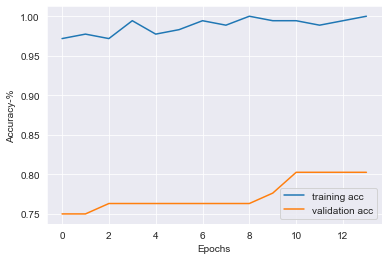

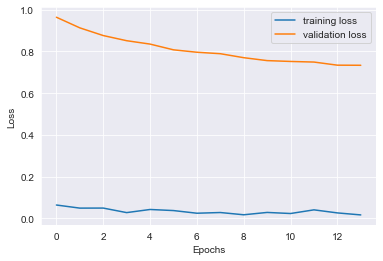

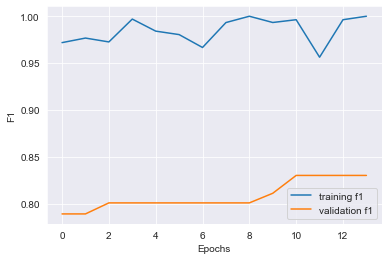

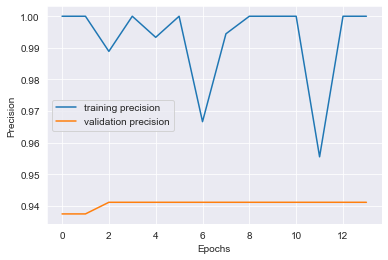

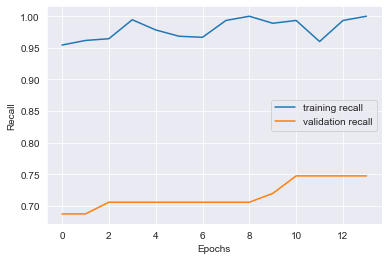

In [19]:
train_result = model.evaluate(x_train,y_train)
val_result = model.evaluate(x_test,y_test)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc','f1_m','precision_m','recall_m'])
no_augmented_df


ypred_val = model.predict(x_test)
ypred_val = np.array([1 if x > 0.5 else 0 for x in ypred_val])

print(confusion_matrix(y_test, ypred_val))
print('\n',classification_report(ypred_val,y_test))


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1 = history.history['f1_m']
val_f1 = history.history['val_f1_m']
precision = history.history['precision_m']
val_precision = history.history['val_precision_m']
recall = history.history['recall_m']
val_recall = history.history['val_recall_m']
epochs = range(len(acc))

plt.plot(epochs, acc, label='training acc')
plt.plot(epochs, val_acc, label='validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy-%')
plt.legend()
#plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\model_acc.png")
plt.savefig("C:\\Users\\Tiago\\Universidade de Aveiro\\Vasco Costa - AIA\\figs\\model_acc.png")
plt.figure()

plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\model_loss.png")
plt.savefig("C:\\Users\\Tiago\\Universidade de Aveiro\\Vasco Costa - AIA\\figs\\model_loss.png")
plt.figure()

plt.plot(epochs, f1, label='training f1')
plt.plot(epochs, val_f1, label='validation f1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()
#plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\model_f1.png")
plt.savefig("C:\\Users\\Tiago\\Universidade de Aveiro\\Vasco Costa - AIA\\figs\\model_f1.png")
plt.figure()

plt.plot(epochs, precision, label='training precision')
plt.plot(epochs, val_precision, label='validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
#plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\model_precision.png")
plt.savefig("C:\\Users\\Tiago\\Universidade de Aveiro\\Vasco Costa - AIA\\figs\\model_precision.png")
plt.figure()

plt.plot(epochs, recall, label='training recall')
plt.plot(epochs, val_recall, label='validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
#plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\model_recall.png")
plt.savefig("C:\\Users\\Tiago\\Universidade de Aveiro\\Vasco Costa - AIA\\figs\\model_recall.png")


In [13]:
base_learning_rate = 0.0000034
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss='binary_crossentropy',
              metrics = ['acc', f1_m, precision_m, recall_m])

In [14]:
epochs = 80

checkpoint = tf.keras.callbacks.ModelCheckpoint('model/model_best.h5', monitor='acc', verbose=1, mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="acc", mode="max",restore_best_weights=True, patience=10)
callbacks_list = [checkpoint,early]
history2 = model.fit(x_train, y_train,
            steps_per_epoch=30,
            epochs=epochs,
            validation_data = (x_test, y_test),
            verbose=1,
            class_weight=class_weights,
            callbacks=callbacks_list)

Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 0.0633 - acc: 0.9718 - f1_m: 0.9719 - precision_m: 1.0000 - recall_m: 0.9544
Epoch 1: acc improved from -inf to 0.97175, saving model to model\model_best.h5
30/30 [==============================] - 8s 236ms/step - loss: 0.0633 - acc: 0.9718 - f1_m: 0.9719 - precision_m: 1.0000 - recall_m: 0.9544 - val_loss: 0.9641 - val_acc: 0.7500 - val_f1_m: 0.7891 - val_precision_m: 0.9375 - val_recall_m: 0.6872
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 0.0484 - acc: 0.9774 - f1_m: 0.9767 - precision_m: 1.0000 - recall_m: 0.9617
Epoch 2: acc improved from 0.97175 to 0.97740, saving model to model\model_best.h5
30/30 [==============================] - 6s 207ms/step - loss: 0.0484 - acc: 0.9774 - f1_m: 0.9767 - precision_m: 1.0000 - recall_m: 0.9617 - val_loss: 0.9131 - val_acc: 0.7500 - val_f1_m: 0.7891 - val_precision_m: 0.9375 - val_recall_m: 0.6872
Epoch 3/50
30/30 [==============================] - ETA: 

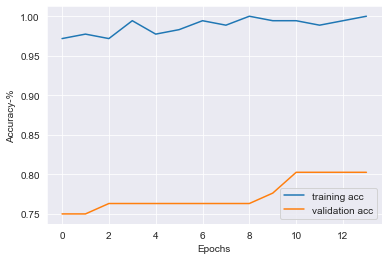

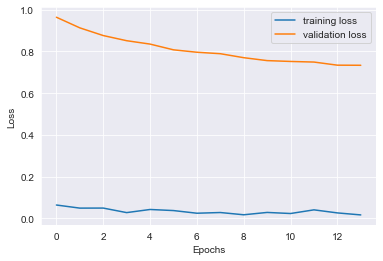

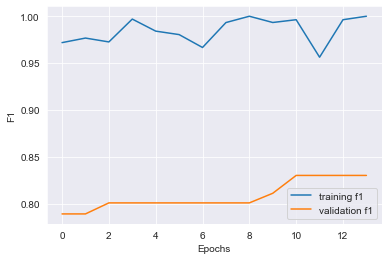

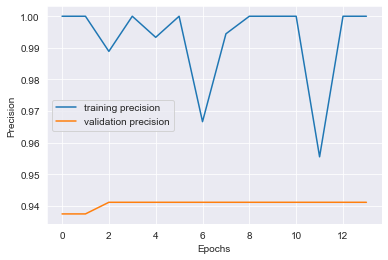

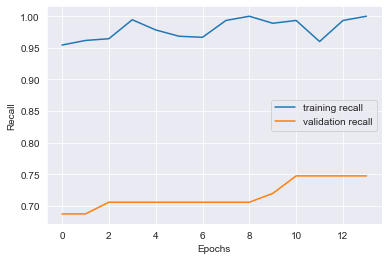

In [21]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
f1 = history2.history['f1_m']
val_f1 = history2.history['val_f1_m']
precision = history2.history['precision_m']
val_precision = history2.history['val_precision_m']
recall = history2.history['recall_m']
val_recall = history2.history['val_recall_m']
epochs = range(len(acc))

plt.plot(epochs, acc, label='training acc')
plt.plot(epochs, val_acc, label='validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy-%')
plt.legend()
#plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\model2_acc.png")
plt.savefig("C:\\Users\\Tiago\\Universidade de Aveiro\\Vasco Costa - AIA\\figs\\model2_acc.png")
plt.figure()

plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\model2_loss.png")
plt.savefig("C:\\Users\\Tiago\\Universidade de Aveiro\\Vasco Costa - AIA\\figs\\model2_loss.png")
plt.figure()

plt.plot(epochs, f1, label='training f1')
plt.plot(epochs, val_f1, label='validation f1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()
#plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\model2_f1.png")
plt.savefig("C:\\Users\\Tiago\\Universidade de Aveiro\\Vasco Costa - AIA\\figs\\model2_f1.png")
plt.figure()

plt.plot(epochs, precision, label='training precision')
plt.plot(epochs, val_precision, label='validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
#plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\model2_precision.png")
plt.savefig("C:\\Users\\Tiago\\Universidade de Aveiro\\Vasco Costa - AIA\\figs\\model2_precision.png")
plt.figure()

plt.plot(epochs, recall, label='training recall')
plt.plot(epochs, val_recall, label='validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
#plt.savefig("C:\\Users\\Vasco Costa\\OneDrive - Universidade de Aveiro\\Grupo\\AIA\\figs\\model2_recall.png")
plt.savefig("C:\\Users\\Tiago\\Universidade de Aveiro\\Vasco Costa - AIA\\figs\\model2_recall.png")

In [23]:
train_result = model.evaluate(x_train,y_train)
val_result = model.evaluate(x_test,y_test)

no_augmented_df = pd.DataFrame(zip(train_result,val_result),columns=['Train','Val'],index=['Loss','Acc','f1_m','precision_m','recall_m'])
no_augmented_df


ypred_val = model.predict(x_test)
ypred_val = np.array([1 if x > 0.5 else 0 for x in ypred_val])

print(confusion_matrix(y_test, ypred_val))
print('\n',classification_report(ypred_val,y_test))


3/3 [==============================] - 0s 134ms/step
[[24  3]
 [15 34]]

               precision    recall  f1-score   support

           0       0.89      0.62      0.73        39
           1       0.69      0.92      0.79        37

    accuracy                           0.76        76
   macro avg       0.79      0.77      0.76        76
weighted avg       0.79      0.76      0.76        76

